In [1]:
import pandas as pd
import numpy as np
from src.utils import load_json, load_known_rxns, save_json
from collections import defaultdict

In [2]:
# Load reactions and rules

imt_ops = pd.read_csv("./data/sprhea/JN3604IMT_rules.tsv", sep='\t')
min_ops = pd.read_csv("./data/sprhea/minimal1224_all_uniprot.tsv", sep='\t')

# Make toc for ops-labeled data

In [3]:
sp_ops_raw = load_json("./data/sprhea/known_rxns_swissprot_enzymes_240310.json")
save_to = "../data/sprhea/sp_ops.csv"
op_level = 'imt_rules' # 'min_rules'

id2seq = defaultdict(set)
for _, elt in sp_ops_raw.items():
    if elt[op_level] and elt['enzymes']:
        for e in elt['enzymes']:
                id2seq[e[0]].add(e[1])

# Make sure only one seq per id
for k,v in id2seq.items():
     if len(v) > 1:
          print(k,v)

id2rule = defaultdict(set)
for _, elt in sp_ops_raw.items():
    if elt['imt_rules'] and elt['enzymes']:
        for e in elt['enzymes']:
            for r in elt[op_level]:
                 id2rule[e[0]].add(r)

print(set(id2rule.keys()) ^ set(id2seq.keys())) # Make sure these are the same

data = {'Entry':[], 'Label':[], 'Sequence':[]}
for id in id2seq.keys():
     data['Entry'].append(id)
     data['Label'].append(";".join(id2rule[id]))
     data['Sequence'].append(list(id2seq[id])[0])

# Save to sp_ops subdir
df = pd.DataFrame(data=data)
df.to_csv(save_to, index=False, sep='\t')
df.head()

set()


,Entry,Label,Sequence
0,A1Z1Q3,rule0310_1;rule0007_197;rule0007_198;rule0006_...,MYPSNKKKKVWREEKERLLKMTLEERRKEYLRDYIPLNSILSWKEE...
1,A0A009IHW8,rule0310_1;rule0311_1,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
2,A0A024B7W1,rule0010_65;rule0011_51;rule0120_1;rule0121_1,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...
3,A0A059TC02,rule0142_1;rule0143_2,MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...
4,A0A061AE05,rule0015_34;rule0014_29,MLTPRDENNEGDAMPMLKKPRYSSLSGQSTNITYQEHTISREERAA...


In [37]:
from src.utils import construct_sparse_adj_mat

y, idx_sample, idx_feature = construct_sparse_adj_mat("sprhea", "sp_ops")

Constructing sp_ops sparse adjacency matrix


In [6]:
y.shape

(3660, 2271)

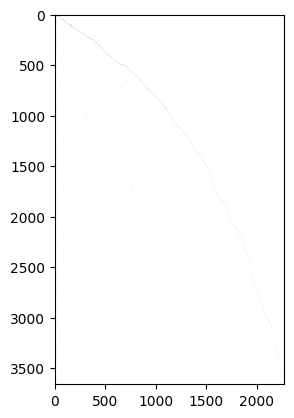

In [41]:
import matplotlib.pyplot as plt

plt.imshow(y.toarray(), cmap='binary')

In [49]:
y.count_nonzero() / (y.shape[0] * y.shape[1])

0.0010321396173660288

# Fold reaction directions into single entries and save known reactions

In [3]:
known_rxns = load_known_rxns("./data/sprhea/known_rxns_swissprot_enzymes_240310_v2.json")

In [4]:
# Filter out transport reactions

transports = set()
for k,v in known_rxns.items():
    if k == v['reverse']:
        transports.add(k)

print(len(transports))

for k in transports:
    known_rxns.pop(k)

872


In [5]:
# How many krs w/ >1 min rule?
i = 0
degen = defaultdict(list)
for k,v in known_rxns.items():
    if len(v['min_rules']) > 1:
        i +=1
        degen[tuple(v['min_rules'])].append(k)
print(i)

sorted_ks = sorted(degen.keys(), key= lambda x : len(degen[x]), reverse=True)
for k in sorted_ks:
    print(k, len(degen[k]))

673
('rule0007', 'rule0125') 86
('rule0006', 'rule0124') 86
('rule0002', 'rule0754') 44
('rule0003', 'rule0753') 44
('rule0001', 'rule1088') 40
('rule0001', 'rule0384') 32
('rule0028', 'rule0250') 24
('rule0007', 'rule0125', 'rule0605') 23
('rule0006', 'rule0124', 'rule0604') 23
('rule0086', 'rule0349') 19
('rule0079', 'rule0126') 18
('rule0029', 'rule0126') 18
('rule0125', 'rule0605') 16
('rule0124', 'rule0604') 15
('rule0004', 'rule1005') 14
('rule0005', 'rule1004') 14
('rule0172', 'rule0936') 8
('rule0079', 'rule0150') 8
('rule0028', 'rule0172') 6
('rule0002', 'rule0347') 6
('rule0003', 'rule0348') 6
('rule0028', 'rule0130') 4
('rule0002', 'rule0347', 'rule0754') 4
('rule0003', 'rule0348', 'rule0753') 4
('rule0028', 'rule0130', 'rule0936') 4
('rule0028', 'rule0040') 4
('rule0126', 'rule0324') 4
('rule0250', 'rule0936') 4
('rule0052', 'rule1209') 4
('rule0054', 'rule1210') 4
('rule0130', 'rule0936') 4
('rule0001', 'rule0126') 4
('rule0380', 'rule0981') 3
('rule0009', 'rule0513') 3
('

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import rdkit
print(rdkit.__version__)

2023.09.5


In [7]:
min_ops.set_index("Name", inplace=True)
min_ops.head()

,Reactants,SMARTS,Products,Comments
Name,,,,
rule0001,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A060PLD9;A0A0P0YNP7;A0A0P9RZM9;A1XCQ0;A3E242...
rule0002,Any;NAD_CoF,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,NADH_CoF;Any,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
rule0003,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
rule0004,Any;NADH_CoF;O2,[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6...,Any;NAD_CoF;WATER,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
rule0005,Any;NAD_CoF;WATER,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,Any;NADH_CoF;O2,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...


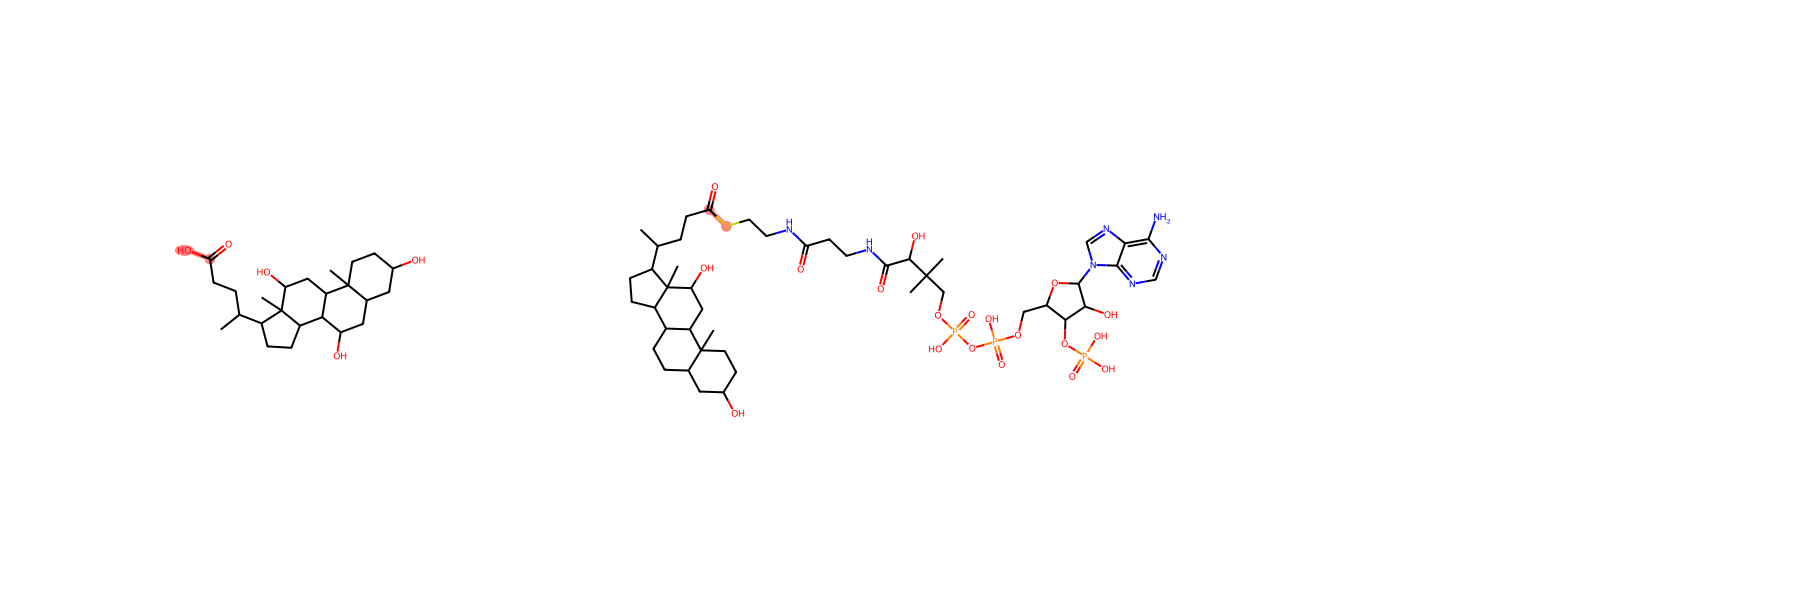

In [8]:
rules = ('rule0079', 'rule0150')
rule_idx = 0
rxn_idx = 0
rule_smarts = [min_ops.loc[rule, "SMARTS"] for rule in rules]
entry = known_rxns[degen[rules][rxn_idx]]
rxn_sma = entry['smarts']
rs, ps = [elt.split('.') for elt in rxn_sma.split('>>')]
hatoms = entry['rcs'][rule_idx]
rev_hatoms = known_rxns[entry['reverse']]['rcs'][rule_idx]
Draw.MolsToGridImage([Chem.MolFromSmiles(r) for r in rs], highlightAtomLists=hatoms, subImgSize=(600, 600))

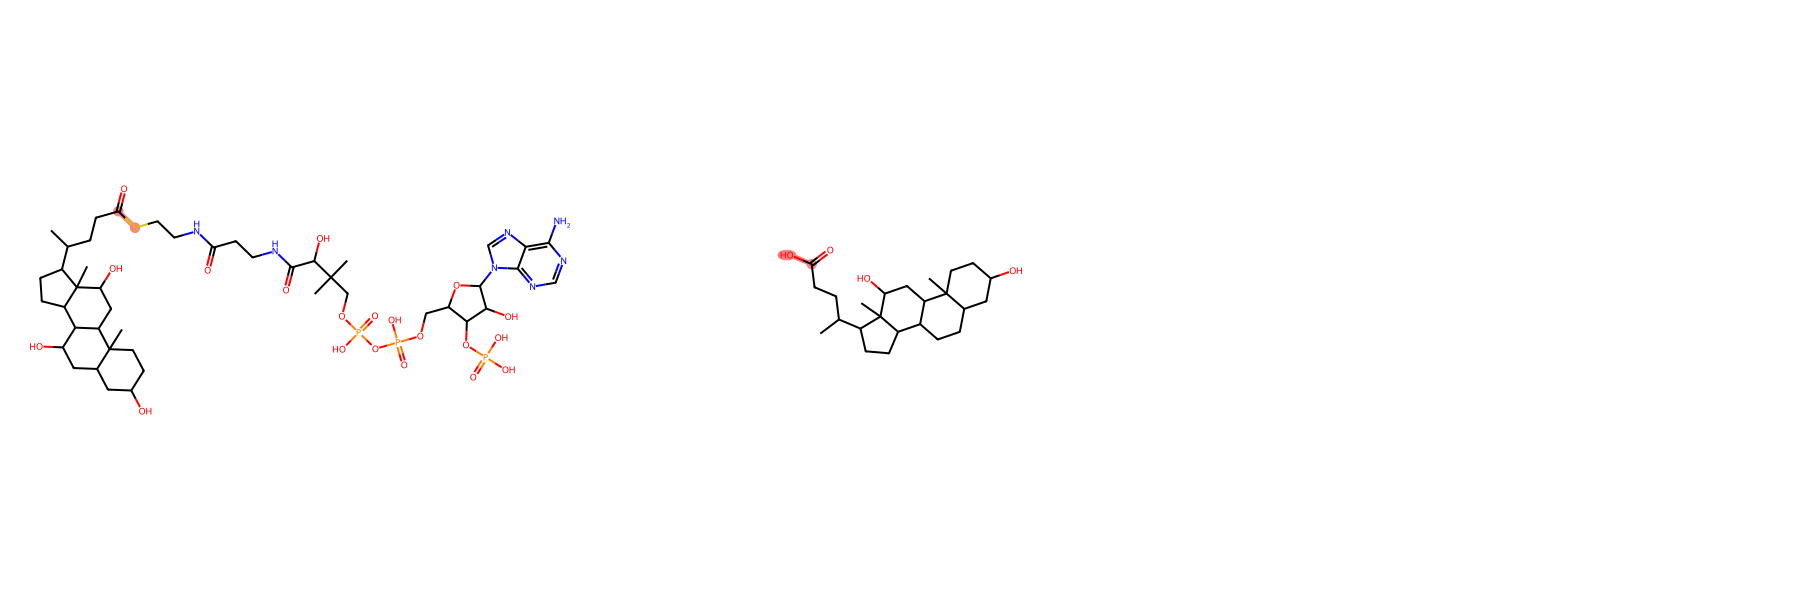

In [9]:
Draw.MolsToGridImage([Chem.MolFromSmiles(p) for p in ps], highlightAtomLists=rev_hatoms, subImgSize=(600, 600))

In [10]:
# Fix or remove multiply mapped reaction entries

manual_fixes = {
    ('rule0007', 'rule0125') : ['rule0125'],
    ('rule0006', 'rule0124') : ['rule0124'],
    ('rule0002', 'rule0754') : ['rule0002'],
    ('rule0003', 'rule0753') : ['rule0003'],
    ('rule0001', 'rule1088') : ['rule0001'],
    ('rule0001', 'rule0384') : ['rule0001'],
    ('rule0028', 'rule0250') : ['rule0250'],
    ('rule0007', 'rule0125', 'rule0605') : ['rule0007'],
    ('rule0006', 'rule0124', 'rule0604') : ['rule0006'],
    ('rule0086', 'rule0349') : ['rule0086'],
    ('rule0079', 'rule0126') : ['rule0079'],
    ('rule0029', 'rule0126') : ['rule0029'],
    ('rule0125', 'rule0605') : ['rule0125'],
    ('rule0124', 'rule0604') : ['rule0124'],
    ('rule0004', 'rule1005') : ['rule0004'],
    ('rule0005', 'rule1004') : ['rule0005'],
    ('rule0172', 'rule0936') : ['rule0172']
}

for k,v in degen.items():
    if k in manual_fixes:
        replacement = manual_fixes[k]
        correct_rc_idx  = k.index(replacement[0])

        print(replacement, correct_rc_idx)
        
        for rhash in v:
            known_rxns[rhash]['min_rules'] = replacement
            known_rxns[rhash]['rcs'] = [known_rxns[rhash]['rcs'][correct_rc_idx]]

    else:
        for rhash in v:
            known_rxns.pop(rhash)

['rule0125'] 1
['rule0124'] 1
['rule0250'] 1
['rule0125'] 0
['rule0124'] 0
['rule0007'] 0
['rule0006'] 0
['rule0002'] 0
['rule0003'] 0
['rule0001'] 0
['rule0001'] 0
['rule0086'] 0
['rule0079'] 0
['rule0029'] 0
['rule0172'] 0
['rule0004'] 0
['rule0005'] 0


In [11]:
# Filter out entries with out rcs
# Check that every entry's reverse is in known rxns

krs_w_rcs = {k:v for k,v in known_rxns.items() if v['rcs']}
len(krs_w_rcs)

missing_revs = set()
for k,v in krs_w_rcs.items():
    if v['reverse'] not in krs_w_rcs:
        missing_revs.add(k)

print(len(missing_revs))

for k in missing_revs:
    krs_w_rcs.pop(k)

print(len(krs_w_rcs))

61
14188


In [12]:
# Fold reaction directions into single entry

'''
Keep smarts arbitrarily in direction of hash sampled as fwd
Hold tuple of min_rules (lr_rule, rl_rule)
Hold tuple of rc tuples (lr_rc_tup, rl_rc_tup)
Forget imt_rules
Consolidate enzymes into 1 set
Consolidate db_entries into 1 set
Keep reverse hash
'''

# Enzyme filtering criteria
whitelist = ['Evidence at protein level', 'Evidence at transcript level', 'Inferred from homology']

kr_folded = {}
processed = []
for rhash in krs_w_rcs.keys():
    rhash_rev = krs_w_rcs[rhash]['reverse']
    if rhash in processed or rhash_rev in processed:
        continue
    else:
        consolidated_enzymes = list(set(krs_w_rcs[rhash]['enzymes'] + krs_w_rcs[rhash_rev]['enzymes']))
        consolidated_enzymes = [e for e in consolidated_enzymes if e.existence in whitelist]
        kr_folded[rhash] = {
            'smarts': krs_w_rcs[rhash]['smarts'],
            'min_rules': krs_w_rcs[rhash]['min_rules'] + krs_w_rcs[rhash_rev]['min_rules'],
            'rcs': krs_w_rcs[rhash]['rcs'] + krs_w_rcs[rhash_rev]['rcs'],
            'enzymes': consolidated_enzymes,
            'db_entries': list(set(krs_w_rcs[rhash]['db_entries'] + krs_w_rcs[rhash_rev]['db_entries'])),
            'reverse': rhash_rev
        }

        processed += [rhash, rhash_rev]

print(len(kr_folded))
save_json(kr_folded, "./data/sprhea/known_rxns_240310_v2_folded_protein_transcript_homology.json")

7094


In [13]:
up2e = {}
for k,v in kr_folded.items():
    for e in v['enzymes']:
        up2e[e.uniprot_id] = e

In [14]:
# Save toc to file
save_to = "./data/sprhea/sp_folded_pth.csv"

# Filter out duplicate sequences

# Seq to upid dict
unique_seqs = defaultdict(set)
for k,v in kr_folded.items():
    for e in v['enzymes']:
        unique_seqs[e.sequence].add(e.uniprot_id)

for k,v in unique_seqs.items():
    unique_seqs[k] = sorted(v)

# Make toc csv thing
chosen_upid_to_rhashes = defaultdict(set)
chosen_upid_to_sequence = {}
for k,v in kr_folded.items():
    for e in v['enzymes']:
        seq = e.sequence
        chosen_upid = unique_seqs[seq][0] # Choose first of sorted upids of unique seq
        chosen_upid_to_rhashes[chosen_upid].add(k)
        chosen_upid_to_sequence[chosen_upid] = seq

data = {'Entry':[], 'Label':[], 'Sequence':[]}
for id in chosen_upid_to_sequence.keys():
     data['Entry'].append(id)
     data['Label'].append(";".join(chosen_upid_to_rhashes[id]))
     data['Sequence'].append(chosen_upid_to_sequence[id])

# Save to sp_ops subdir
df = pd.DataFrame(data=data)
df.to_csv(save_to, index=False, sep='\t')
df.head()


,Entry,Label,Sequence
0,C0RGW8,R84126efbb9122177f50f81fcff58422c31a5cf7ef7254...,MSSYSSNIDRLQREIARLKADDSREMSKEKQAQSKAHKAQQAISSA...
1,F4JT82,R84126efbb9122177f50f81fcff58422c31a5cf7ef7254...,MVDGKEVYISFNRWEDTIRHSFVSHLSAEFQRKGVSVFASEDSASD...
2,O35975,R84126efbb9122177f50f81fcff58422c31a5cf7ef7254...,MTSKIFKFFLTWWLTQQVTGLAVPFMLDMAPNAFDDQYESCVEDME...
3,Q9SCX7,R84126efbb9122177f50f81fcff58422c31a5cf7ef7254...,METSSISTVEDKPPQHQVFINFRGADLRRRFVSHLVTALKLNNINV...
4,O95256,R84126efbb9122177f50f81fcff58422c31a5cf7ef7254...,MLCLGWIFLWLVAGERIKGFNISGCSTKKLLWTYSTRSEEEFVLFC...


In [36]:
len(df)

27834

In [18]:
k = list(krs_w_rcs.keys())[0]
print(krs_w_rcs[k])
print(krs_w_rcs[krs_w_rcs[k]['reverse']])
print(krs_w_rcs[k].keys())

{'smarts': 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1.O>>NC(=O)c1cccnc1.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OCC2OC(O)C(O)C2O)C(O)C1O', 'imt_rules': ['rule0311_1'], 'min_rules': ['rule0311'], 'enzymes': [Enzyme(uniprot_id='Q28FQ6', sequence='MMAAGVSRFRGSLLGALLGDCIGAVFEGHTNVTKEFLFDYMKSLDKGERLKRVLTYTDDTAMARSIVQSVLENYEFNIEDLANRFTTEYNRDPDRGYGMAVVHVFEKLGSGEYKHVFSPAREQFDGKGSYGNGAAMRVVGISLAYPRIPDIIEYARTSGMLTHASSLGYNGAILQALAVHYALQGELAPETFLDQLLDHMKEVETDKKSRSDALELEMDEFPYCNKLRKIKAFLAREDVTRKDIVKELGNGIQAFESVPTAIYSFLRCLKPVSELPSELTNLQRTIAFCILLGGDTDTIATMAAAIAGAYHGEEQIPLNWKLSAEGYKDAEDWGEKLHQLYCRRLQSTTS', ec=('3.2.1.143',), validation_score=1.0, existence='Evidence at transcript level', reviewed='reviewed', organism='Xenopus tropicalis (Western clawed frog) (Silurana tropicalis)'), Enzyme(uniprot_id='F1QWA8', sequence='MFLSLVVYLSKICRYLSMFSSDRLTVPEYVSSRLHNRRTAPDPRAVSPGISTDVQAVLDGSLPALRSAIRTLRSSKDTGDLEETRRAIAETFQLVEEAWVLPTVGRRVAEEICNRIRLDGGLELLLQLMQTPAVEITYESAKLLE

# Consolidate swissprot esm embeddings

In [8]:
import os
from tqdm import tqdm
import subprocess
import csv
from src.utils import load_embed

In [13]:
in_dir = "/projects/p30041/spn1560/hiec/data/sprhea/esm_240524"
out_dir = "/projects/p30041/spn1560/hiec/data/sprhea/esm"

mismatches = []
for fn in tqdm(os.listdir(in_dir)):
    if fn in os.listdir(out_dir):
        in_id, in_embed = load_embed(f"{in_dir}/{fn}", embed_key=33)
        out_id, out_embed = load_embed(f"{out_dir}/{fn}", embed_key=33)
        
        if all(in_embed == out_embed):
            continue
        elif all((in_embed - out_embed) < 1e-5):
            subprocess.run(['cp', f"{in_dir}/{fn}", f"{out_dir}/"])
        else:
            mismatches.append((in_id, out_id))
    else:
        subprocess.run(['cp', f"{in_dir}/{fn}", f"{out_dir}/"])
            
            


100%|██████████| 3660/3660 [01:11<00:00, 50.83it/s]


In [14]:
for fn in tqdm(os.listdir(in_dir)):
    if fn not in os.listdir(out_dir):
        in_id, in_embed = load_embed(f"{in_dir}/{fn}", embed_key=33)
        out_id, out_embed = load_embed(f"{out_dir}/{fn}", embed_key=33)
        print(in_id)

100%|██████████| 3660/3660 [00:34<00:00, 104.62it/s]


In [27]:
'''
TODO: Repeat ^^ for swissprot (from CLEAN paper)
'''

False

In [10]:
# Put remaining uniprot ids into a fasta file

def csv_to_fasta(csv_name, existing_data, fasta_name):
    csvfile = open(csv_name, 'r')
    csvreader = csv.reader(csvfile, delimiter='\t')
    outfile = open(fasta_name, 'w')
    for i, rows in tqdm(enumerate(csvreader)):
        if i > 0:
            if f"{rows[0]}.pt" in os.listdir(existing_data):
                continue
            else:
                outfile.write('>' + rows[0] + '\n')
                outfile.write(rows[2] + '\n')

dataset = 'sprhea'
toc = 'sp_folded_pth'
existing_data = "/projects/p30041/spn1560/hiec/data/sprhea/esm"
csv_path = f"./data/{dataset}/{toc}.csv"
fasta_name = f"./data/{dataset}/{toc}.fasta"
csv_to_fasta(csv_path, existing_data, fasta_name)

117171it [19:20, 100.95it/s]


# Look at how many enyzmes per reaction, reactions per enzymes in sprhea folded

In [6]:
import scipy as sp
import numpy as np
import pandas as pd
from collections import Counter
def construct_sparse_adj_mat(ds_name, toc):
        '''
        Returns sparse representation of sample x feature adjacency matrix
        and lookup of sample names from row idx key.

        Args
            - ds_name: Str name of dataset
            - toc: Table of contents csv

        Returns
            -
        '''      
        # Load from dataset "table of contents csv"
        df = pd.read_csv(f"./data/{ds_name}/{toc}.csv", delimiter='\t')
        df.set_index('Entry', inplace=True)
        sample_idx = {}
        feature_idx = {}
        
        # Construct ground truth protein-function matrix
        print(f"Constructing {ds_name}:{toc} sparse adjacency matrix")
        row, col, data = [], [], [] # For csr
        for i, elt in enumerate(df.index):
            labels = df.loc[elt, 'Label'].split(';')
            sample_idx[elt] = i
            for label in labels:
                if label in feature_idx:
                    j = feature_idx[label]
                else:
                    j = len(feature_idx)
                    feature_idx[label] = j
                row.append(i)
                col.append(j)
                data.append(1)
                
            print(f"{i}", end='\r')

        adj = sp.sparse.csr_matrix((data, (row, col)), shape=(len(sample_idx), len(feature_idx)))
        idx_sample = {v:k for k,v in sample_idx.items()}
        idx_feature = {v:k for k,v in feature_idx.items()}
            
        return adj, idx_sample, idx_feature

Constructing sprhea:sp_folded_pth sparse adjacency matrix
117170 enzymes
7092 reactions
22.375634517766496 proteins per reaction
1.3543398480839806 reactions per protein
Constructing sprhea:sp_folded_pt sparse adjacency matrix
27833

27834 enzymes
7056 reactions
7.758219954648526 proteins per reaction
1.9667313357763887 reactions per protein


In [ ]:
dataset = 'sprhea'
toc = 'sp_folded_pth'
adj, idx_sample, idx_feature = construct_sparse_adj_mat(dataset, toc)
print(adj.shape[0], 'enzymes')
print(adj.shape[1], 'reactions')
print(adj.sum(axis=0).mean(), "proteins per reaction")
print(adj.sum(axis=1).mean(), "reactions per protein")

labels_per_prot = np.array(adj.sum(axis=1)).reshape(-1,)
ct = Counter(labels_per_prot)
x, h = list(ct.keys()), list(ct.values())
plt.bar(x, h)
plt.yscale('log')
plt.xticks(np.arange(1, max(x) + 1))
plt.ylabel("# enzymes")
plt.xlabel("# reactions")
plt.xticks(rotation=90)
plt.show()

prots_per_label = np.array(adj.sum(axis=0)).reshape(-1,)
ct = Counter(prots_per_label)
x, h = list(ct.keys()), list(ct.values())
plt.figure(figsize=(9,6))
plt.bar(x, h)
plt.yscale('log')
plt.xticks(np.arange(1, max(x) + 1))
plt.ylabel("# reactions")
plt.xlabel("# enzymes")
plt.xticks(rotation=90)
plt.xscale('log')
plt.show()

In [ ]:
dataset = 'sprhea'
toc = 'sp_folded_pt'
adj, idx_sample, idx_feature = construct_sparse_adj_mat(dataset, toc)
print(adj.shape[0], 'enzymes')
print(adj.shape[1], 'reactions')
print(adj.sum(axis=0).mean(), "proteins per reaction")
print(adj.sum(axis=1).mean(), "reactions per protein")

labels_per_prot = np.array(adj.sum(axis=1)).reshape(-1,)
ct = Counter(labels_per_prot)
x, h = list(ct.keys()), list(ct.values())
plt.bar(x, h)
plt.yscale('log')
plt.xticks(np.arange(1, max(x) + 1))
plt.ylabel("# enzymes")
plt.xlabel("# reactions")
plt.xticks(rotation=90)
plt.show()

prots_per_label = np.array(adj.sum(axis=0)).reshape(-1,)
ct = Counter(prots_per_label)
x, h = list(ct.keys()), list(ct.values())
plt.figure(figsize=(9,6))
plt.bar(x, h)
plt.yscale('log')
plt.xticks(np.arange(1, max(x) + 1))
plt.ylabel("# reactions")
plt.xlabel("# enzymes")
plt.xticks(rotation=90)
plt.xscale('log')
plt.show()

# Make folded reactions x min ops labels tocs

In [10]:
from src.utils import load_known_rxns
import pandas as pd

In [11]:
krs = load_known_rxns("./data/sprhea/known_rxns_240310_v2_folded_protein_transcript.json")
save_to = "./data/sprhea/sp_folded_pt_rxns_x_min_ops.csv"

In [12]:
# Make sure all entreis have exactly two min ops
for k,v in krs.items():
    if len(v['min_rules']) != 2:
        print(v)
        break

In [15]:
# Make toc
data = {'Entry':[], 'Label':[]}
for k,v in krs.items():
     min_ops = sorted(v['min_rules']) # Canonical order
     data['Entry'].append(k)
     data['Label'].append("_".join(min_ops))

# Save to sp_ops subdir
df = pd.DataFrame(data=data)
df.to_csv(save_to, index=False, sep='\t')
df.head()

,Entry,Label
0,R84126efbb9122177f50f81fcff58422c31a5cf7ef7254...,rule0310_rule0311
1,R922e16ad056d0d9e87f61239c734efcf9fafb99c77cc3...,rule0120_rule0121
2,R8d9c400039c4568d063fa0a51b012da463f56d8a598cf...,rule0010_rule0011
3,R5386d7c400c7c774dc0d52a933c7b4f676c4effc8a72b...,rule0142_rule0143
4,R57b2bc5bcccd3d7e9a71b4c948ad01d180e83e03cd89e...,rule0142_rule0143


In [18]:
len(set(df.loc[:, 'Label'])), len(df)

(434, 7094)